Requirements

In [ ]:
# !pip uninstall -y jax jaxlib flax
# !pip install jax==0.4.19 jaxlib==0.4.19 flax==0.8.3
# !pip install diffusers==0.20.2
# !pip install huggingface_hub==0.25.0
# !pip install -q inference-gpu[yolo-world]==0.9.12rc1
# !git clone --recursive https://github.com/AILab-CVC/YOLO-World
# %cd YOLO-World/
# !pip install -q supervision==0.19.0rc3
# !pip install torchmetrics

In [ ]:
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline
import unet_2d_condition
from diffusers import LMSDiscreteScheduler
from PIL import Image
import math
from PIL import Image, ImageDraw, ImageFont
import torch
from tqdm.auto import tqdm

device= "cuda" if torch.cuda.is_available() else "cpu"

**Loading Model**

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
import unet_2d_condition
import math
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm

device= "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    variant="fp16",
    force_download=True,  
).to(device)

In [ ]:
unet = unet_2d_condition.UNet2DConditionModel.from_pretrained(
    'sd-legacy/stable-diffusion-v1-5',
    variant="fp16",
    subfolder="unet",
)

pipe.unet = unet 
pipe.to(device)

In [12]:
cfg = {
    # General Configuration
    "general": {
        "save_path": "/content/drive/MyDrive/Colab Notebooks/Layout Guidance/Code/Images",
        "model_path": "stabilityai/stable-diffusion-2-1",
        "unet_config": "/content/drive/MyDrive/Colab Notebooks/Layout Guidance/Code/conf/unet/config.json"
    },
    # Inference Configuration
    "inference": {
        "loss_scale": 30,
        "batch_size": 1,
        "loss_threshold": 0.05, 
        "max_iter": 3, 
        "max_index_step": 10,
        "timesteps": 51,
        "classifier_free_guidance": 11, 
        "rand_seed": 445,
        "height":768,
        "width":768,
        "num_channels_latent":4,
        "text_encoder_lora_scale":None,
        "do_classifier_free_guidance":True,
        "num_inference_steps":100,
    },
    # Noise Configuration
    "noise_schedule": {
        "beta_start": 0.00085,
        "beta_end": 0.012,
        "beta_schedule": "scaled_linear",
        "num_train_timesteps": 1000
    }
}

In [13]:
def calculate_overlap_masks(bboxes, H, W):
    """ Create a mask for each bbox and calculate the overlap count for each pixel """
    overlap_count = torch.zeros((H, W)).cuda()
    masks = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = [int(dim) for dim in bbox[0]]
        mask = torch.zeros((H, W)).cuda()
        mask[y_min:y_max, x_min:x_max] = 1
        masks.append(mask)
        overlap_count += mask
    normalized_masks = [mask / overlap_count.clamp(min=1) for mask in masks]
    return normalized_masks


In [ ]:
def calculate_entropy(attn_map, epsilon=1e-5):
    attn_within_box = attn_map / (attn_map.sum() + epsilon)  # Normalize to probability distribution
    entropy = -torch.sum(attn_within_box * torch.log(attn_within_box + epsilon))
    return entropy.item()  # Return as a scalar

In [14]:
def Phrase2idx(prompt, phrases):
    phrases = [x.strip() for x in phrases.split(';')]
    prompt_list = prompt.strip('.').split(' ')
    results = {'words': [], 'positions': []}

    for phrase in phrases:
        phrase_words = phrase.split(' ')
        phrase_positions = []
        for word in phrase_words:
            try:
                word_position = prompt_list.index(word) + 1
                phrase_positions.append(word_position)
            except ValueError:
                print(f"Warning: '{word}' not found in prompt.")
                continue
        if phrase_positions:
            results['words'].append([phrase])  
            results['positions'].append(phrase_positions)  

    return results


def draw_box(pil_img, bboxes, phrases):
    draw = ImageDraw.Draw(pil_img)
    try:
        font = ImageFont.truetype('./FreeMono.ttf', 25)
    except IOError:
        font = ImageFont.load_default()
    for obj_bboxes, phrase in zip(bboxes, phrases):
        for obj_bbox in obj_bboxes:
            x_0, y_0, x_1, y_1 = obj_bbox[0], obj_bbox[1], obj_bbox[2], obj_bbox[3]
            draw.rectangle([int(x_0 * 512), int(y_0 * 512), int(x_1 * 512), int(y_1 * 512)], outline='red', width=5)
            coords_text = f"({x_0}, {y_0}) - ({x_1}, {y_1})"
            label = f"{phrase}\n{coords_text}"
            text_position = (int(x_0 * 512) + 5, int(y_0 * 512) + 5)

            draw.multiline_text(text_position, label, font=font, fill=(255, 0, 0))

    return pil_img

**Calculate Energy Function**

In [ ]:
def compute_ca_loss(idx,attn_maps_mid, attn_maps_up,attn_maps_down, bboxes, object_positions, count):
    loss = 0
    object_number = len(bboxes)
    if object_number == 0:
        return torch.tensor(0).float().cuda() if torch.cuda.is_available() else torch.tensor(0).float()

    out_maps = {'words': [], 'maps': [], 'positions': []}

    ca_map_obj = None
    current_box_attention_sum = 0
    obj_loss = 0
    for attn_maps in [attn_maps_up,attn_maps_down]:
        for attn_map in attn_maps: #iterate over all attention maps
            b, i, j = attn_map.shape
            H = W = int(math.sqrt(i))
            total_mask = torch.zeros(size=(H, W)).cuda() if torch.cuda.is_available() else torch.zeros(size=(H, W))

            for all_boxes in bboxes:
                for box in all_boxes:
                    x_min, y_min, x_max, y_max = int(box[0] * W), int(box[1] * H), int(box[2] * W), int(box[3] * H)
                    total_mask[y_min:y_max, x_min:x_max] = 1

            entity_data = {}
            for index,item in enumerate(object_positions['positions']):
                key = item[0]
                if key not in entity_data:
                    entity_data[key] = []
                entity_data[key].append(index)

            for obj_idx in range(object_number): #iterate over all bounding boxes
                obj_loss = 0
                current_mask = torch.zeros(size=(H, W)).cuda() if torch.cuda.is_available() else torch.zeros(size=(H, W))
                for obj_box in bboxes[obj_idx]:
                    x_min, y_min, x_max, y_max = int(obj_box[0] * W), \
                        int(obj_box[1] * H), int(obj_box[2] * W), int(obj_box[3] * H)
                    current_mask[y_min: y_max, x_min: x_max] = 1

                for obj_position in object_positions['positions'][obj_idx]:
                    ca_map_obj = attn_map[:, :, obj_position].reshape(b, H, W)
                    same_entity_mask = torch.zeros_like(current_mask)

                    for keys in entity_data.keys():
                        if keys == obj_position:    
                            for index in entity_data[keys]:
                                for box in bboxes[index]:
                                    x_min, y_min, x_max, y_max = int(box[0] * W), int(box[1] * H), int(box[2] * W), int(box[3] * H)
                                    same_entity_mask[y_min:y_max, x_min:x_max] = 1
                    count[0]+=1
                    valid_attention_area = (1 - same_entity_mask)
                    total_attention_sum = (ca_map_obj * valid_attention_area).reshape(b, -1).sum(dim=-1)
                    current_box_attention_sum = (ca_map_obj * current_mask).reshape(b, -1).sum(dim=-1)

                    activation_value = current_box_attention_sum / total_attention_sum
                    entropy_val = calculate_entropy(current_box_attention_sum)
                    obj_loss += torch.mean(((1-activation_value) ** 2) + 0.5 * entropy_val)

                obj_loss /= len(object_positions['positions'][obj_idx])  # Average loss over all positions for this object
                loss +=obj_loss

    loss = loss / (object_number * (len(attn_maps_up) + len(attn_maps_mid) + len(attn_maps_down)))
    return loss, out_maps

**Inference**

In [16]:
def inference(device, unet, vae, tokenizer, text_encoder, prompt, bboxes, phrases, cfg):
    object_positions = Phrase2idx(prompt, phrases)

    # Encode Classifier Embeddings
    uncond_input = tokenizer(
        [""] * cfg['inference']['batch_size'], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Encode Prompt
    input_ids = tokenizer(
            [prompt] * cfg['inference']['batch_size'],
            padding="max_length",
            truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        )

    cond_embeddings = text_encoder(input_ids.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, cond_embeddings])
    generator = torch.manual_seed(cfg['inference']['rand_seed'])  # Seed generator to create the initial latent noise

    noise_scheduler = LMSDiscreteScheduler(beta_start=cfg['noise_schedule']['beta_start'], beta_end=cfg['noise_schedule']['beta_end'],
                                           beta_schedule=cfg['noise_schedule']['beta_schedule'], num_train_timesteps=cfg['noise_schedule']['num_train_timesteps'])

    latents = torch.randn(
        (cfg['inference']['batch_size'], 4, 64, 64),
        generator=generator,
    ).to(device)

    noise_scheduler.set_timesteps(cfg['inference']['timesteps'])

    latents = latents * noise_scheduler.init_noise_sigma

    loss = torch.tensor(10000)
    loss_list = []
    idx = 0
    forward_iterations = 0
    forward_iterations += 1
    for index, t in tqdm(enumerate(noise_scheduler.timesteps)):
        iteration = 0
        count = [0]
        while loss.item() / cfg['inference']['loss_scale'] > (cfg['inference']['loss_threshold']*len(bboxes)) and iteration < cfg['inference']['max_iter'] and index < cfg['inference']['max_index_step']:
            latents = latents.requires_grad_(True)
            latent_model_input = latents
            latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

            noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down = \
                unet(latent_model_input, t, encoder_hidden_states=cond_embeddings,forward_iteration=forward_iterations,
                     bboxes=bboxes,object_positions=object_positions["positions"])

            loss, out_maps = compute_ca_loss(idx,attn_map_integrated_mid, attn_map_integrated_up,attn_map_integrated_down, bboxes=bboxes,
                                object_positions=object_positions, count=count)
            loss = loss * cfg['inference']['loss_scale']

            grad_cond = torch.autograd.grad(loss.requires_grad_(True), [latents])[0]
            latents = latents - grad_cond * noise_scheduler.sigmas[index] ** 2

            iteration += 1
            torch.cuda.empty_cache()

        with torch.no_grad():
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

            noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down = \
                unet(latent_model_input, t, encoder_hidden_states=text_embeddings,forward_iteration=forward_iterations,
                     bboxes=bboxes,object_positions=object_positions["positions"])
            forward_iterations += 1

            noise_pred = noise_pred.sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + cfg['inference']['classifier_free_guidance'] * (noise_pred_text - noise_pred_uncond)

            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
            torch.cuda.empty_cache()

    with torch.no_grad():
        print("Decode Image...")
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images, loss_list


**Run Model**

0it [00:00, ?it/s]

Decode Image...


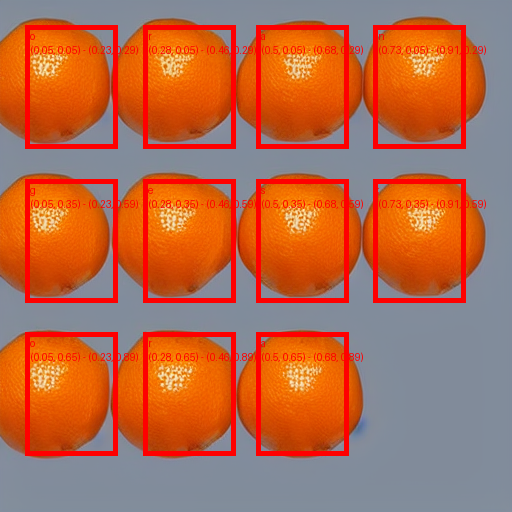

In [17]:
torch.autograd.set_detect_anomaly(True)

prompt = f"an image of 11 oranges."
bboxes = [[[0.05, 0.05, 0.23, 0.29]], [[0.28, 0.05, 0.46, 0.29]], [[0.5, 0.05, 0.68, 0.29]],
          [[0.73, 0.05, 0.91, 0.29]], [[0.05, 0.35, 0.23, 0.59]], [[0.28, 0.35, 0.46, 0.59]],
          [[0.5, 0.35, 0.68, 0.59]], [[0.73, 0.35, 0.91, 0.59]], [[0.05, 0.65, 0.23, 0.89]], [[0.28, 0.65, 0.46, 0.89]], [[0.5, 0.65, 0.68, 0.89]]] 

phrases = "oranges;oranges;oranges;oranges;oranges;oranges;oranges;oranges;oranges;oranges;oranges"

object_positions = Phrase2idx(prompt, phrases)

pil_images, loss_list = inference(device, unet, pipe.vae, pipe.tokenizer, pipe.text_encoder, prompt, bboxes, phrases, cfg)
for index, image in enumerate(pil_images):  
    draw_box(image,bboxes,phrases)
    display(image)      